**NOTES**
* The repository for the previous project referenced to (LaBollita) is no longer available. A copy has been made available at https://github.com/geirtul/scintillator

In [2]:
# Module and data import
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from master_scripts.data_functions import (load_experiment, get_git_root, separation_distance, energy_difference,
                                           relative_energy, event_indices, normalize_image_data, import_real_data)
from master_scripts.analysis_functions import (doubles_classification_stats, singles_classification_stats)
from master_scripts.plotting import plot_roc_curve
from sklearn.metrics import f1_score, roc_curve
%load_ext autoreload
%autoreload 2
repo_root = get_git_root()
FIG_PATH = repo_root + "figures/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Load simulated data
images = np.load(repo_root + "data/simulated/images_full_pixelmod.npy")
positions = np.load(repo_root + "data/simulated/positions_full.npy")
energies = np.load(repo_root + "data/simulated/energies_full.npy")
labels = np.load(repo_root + "data/simulated/labels_full.npy")

# Classification of Electron Events
For this part of the project, the goal is to separate events in the dataset into two categories, 'single' and 'double' electron events. Mainly two paths have been taken in order to do this so far. One using well-known network architectures pretrained on the [ImageNet](http://www.image-net.org/) database. The other using a network architecture developed in an ML-project at MSU, that we train from scratch ([MSU ML-Project, LaBollita](https://github.com/harrisonlabollita/MSU-Machine-Learning-Project)). As a third approach, we implement a model based on the VGG architecture.

## Classification Using Pretrained Models
Pretrained networks have previously been found to perform fairly well on other data than they were trained on,
such as data from the AT-TPC ([Kuchera et. al](https://arxiv.org/abs/1810.10350)). Because these models are trained on complex image data with a large amount of features, the idea is to use them as "feature extractors" on our own image data. Due to modern Python frameworks such as [TensorFlow](https://www.tensorflow.org/), [PyTorch](https://pytorch.org/), and [Keras](https://keras.io/), implementing and testing this approach is fairly straightforward, although not without challenges. The extracted features are then fed through a fully connected
network that we build and train from scratch using data with known labels.

We attempted classification with the following models, all pretrained on ImageNet:
* [DenseNet121, DenseNet169, DensNet201](https://arxiv.org/abs/1608.06993)
* [InceptionResNetV2](https://arxiv.org/abs/1602.07261)
* [InceptionV3](http://arxiv.org/abs/1512.00567)
* [MobileNet](https://arxiv.org/pdf/1704.04861.pdf)
* [MobileNetV2](https://arxiv.org/abs/1801.04381)
* [NASNetLarge, NASNetMobile](https://arxiv.org/abs/1707.07012)
* [ResNet50](https://arxiv.org/abs/1512.03385)
* [VGG16, VGG19](https://arxiv.org/abs/1409.1556)
* [Xception](https://arxiv.org/abs/1610.02357)

See https://keras.io/applications/ for preliminary info about implementation of these models.

One aspect of pretrained models is they could allow testing for feasability for ML applications
to classification or regression tasks, without needing an expensive infrastructure for training
models (looking at you, RTX2080Ti).

### Challenges

#### Input color
The models expect an RGB image as input, meaning dimensions of (height, width, channels), e.g VGG16 has default input (224, 224, 3). We can 'fake' these RGB channels by concatenating our input to itself, making our (16, 16, 1) input (16, 16, 3).

#### Input size and MaxPooling layers
Our data is essentially a 16x16 pixel image. This is far smaller than the expected input size for most,
if not all of these pretrained networks. Without doing any image manipulations, such as padding with additional rows and columns, this stops us from using the full depth of some networks. The typical architectures of these networks contain 'convolutional blocks' followed my a MaxPooling layer. The MaxPooling layers effectively cuts the input size in half for each MaxPooling layer. So for networks where we meet more than three such layers, our input is reduced to a single pixel, and the model will throw an error.

To combat this, the implementation of the models does two things:
1. Replace the input layer with one that accepts our input, (16, 16, 3). There are no weights in the input layer so this does not affect results.
2. Iterate over the layers in the model, adding them to our new model one by one, until we have added all layers or a specific error is thrown. This specific error allows us to catch when our model is too deep, and save the model in the state it is before this error is reached.





#### Are the extracted features viable for classification?
Before starting training of fully-connected networks that use the extracted features from pretrained models as input, we compared the feature distributions of each network to see if it is reasonable to expect classification to work. The distribution for each individual feature, across all provided samples, was compared for single and double events by using the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test). If the difference between the distributions is significant, there should be a meaningful difference between single and double events that allow classification to work.

### Results for pretrained models
The table below containes the results from our experiments with pretrained networks. The networks were trained on 160000 samples and tested on 40000 samples. The dataset was balanced (same number of each type of event present). To increase the robustness of the results we used k-fold cross-validation with 5 folds for all networks. This gives a clearer picture of the actual performance of the network, because without it you can technically get lucky and only have "easy" samples in your validation data the first run and get artificially good results.

| Model           | Min Accuracy | Max accuracy | Mean accuracy
| :---            |     :---:    |     :---:    |    :---:     
|DenseNet121      | 0.92         | 0.93         | 0.92
|DenseNet169      | 0.92         | 0.93         | 0.92
|DenseNet201      | 0.92         | 0.94         | 0.93
|InceptionResNetV2| 0.88         | 0.89         | 0.88
|InceptionV3      | 0.87         | 0.88         | 0.88
|MobileNet        | 0.50         | 0.86         | 0.71
|MobileNetV2      | 0.50         | 0.50         | 0.50
|NASNetLarge      | 0.91         | 0.92         | 0.92
|NASNetMobile     | 0.91         | 0.92         | 0.92
|ResNet50         | 0.50         | 0.50         | 0.50
|VGG16            | 0.91         | 0.92         | 0.91
|VGG19            | 0.88         | 0.90         | 0.89
|Xception         | 0.92         | 0.93         | 0.92

The network with the best accuracy was DenseNet201, both for max and mean accuracy. It is closely followed by the other DenseNet variants, NASNet variants, Xception, and VGG16. We chose DenseNet201 for further study. There are a number of other metrics than accuracy that together provide a deeper insight into the performance of a classifier.


### DenseNet201 Additional Analysis
To gain more insight we produce a few more metrics specifically for the top-performing model.
These metrics are:
* [ROC-Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
* [F1-Score](https://en.wikipedia.org/wiki/F1_score)
* [Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

Specifically for double events, we look for which type of double events are more difficult to classify than others. To find out, we explore the distribution of relative energy and separation distances for events that are misclassified. We expect to find that low separation distances are more difficult as this is currently the case for humans. Double-events with sufficiently low separation distance may be indistinguishable from single-events.

### Which events are difficult to classify
* Plot relative energy without swapping e1 and e2 to constrain values to [0,1]
    Done.
* Scatterplot correctly classified events as well
* Investigate if there are some images that are always misclassified across multiple training runs

## Classification with custom model
We base our implemented model on the structure of VGG
and compare the results with the model from previous work ([MSU ML-Project, LaBollita](https://github.com/harrisonlabollita/MSU-Machine-Learning-Project))

In [4]:
# Load experiment and associated model (must be a saved model instance complete with weights)
c_experiment_id = "367e35da671b"
c_experiment = load_experiment(c_experiment_id)
c_model = tf.keras.models.load_model(repo_root + "models/" + c_experiment_id + ".h5")
# Print experiment metrics
print("==== Experiment metrics")
print(json.dumps(c_experiment['metrics'], indent=2))
print("====")

# Get validation indices used in the experiment and predict on validation set
c_val_idx = np.array(c_experiment['indices']['fold_0']['val_idx'])
# Predict on the validation set
c_prediction = c_model.predict(normalize_image_data(images[c_val_idx]))
c_val_pred = (c_prediction > 0.5).astype(int)

==== Experiment metrics
{
  "accuracy_score": 0.9859178947368421,
  "confusion_matrix": {
    "TN": 236629,
    "FP": 903,
    "FN": 5786,
    "TP": 231682
  },
  "f1_score": 0.9857696898009374,
  "matthews_corrcoef": 0.9720411813174418,
  "roc_auc_score": 0.9938551759726573
}
====


F1-score for double events separated by less than 1 pixel: 0.6358333333333334
F1-score for double events separated by more than 1 pixel: 0.9893799717573019
F1-score for all events: 0.9857696898009374


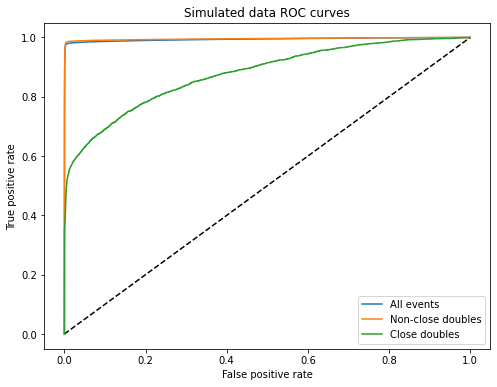

In [7]:
# Setup indices
c_s_idx, c_d_idx, c_c_idx = event_indices(positions[c_val_idx])
c_non_close_idx = np.setdiff1d(np.concatenate((c_s_idx, c_d_idx), axis=0), c_c_idx)
c_close_idx = np.concatenate((c_s_idx, c_c_idx), axis=0)

# f1-score for the selections
c_f1_close = f1_score(labels[c_val_idx][c_c_idx], c_val_pred[c_c_idx])
c_f1_non_close = f1_score(labels[c_val_idx][c_non_close_idx], c_val_pred[c_non_close_idx])
print("F1-score for double events separated by less than 1 pixel:", c_f1_close)
print("F1-score for double events separated by more than 1 pixel:", c_f1_non_close)
print("F1-score for all events:", c_experiment['metrics']['f1_score'])

fpr_all, tpr_all, thresholds_all = roc_curve(
    labels[c_val_idx],
    c_prediction
)
fpr_non_close, tpr_non_close, thresholds_non_close = roc_curve(
    labels[c_val_idx[c_non_close_idx]],
    c_prediction[c_non_close_idx]
)
fpr_close, tpr_close, thresholds_close = roc_curve(
    labels[c_val_idx[c_close_idx]],
    c_prediction[c_close_idx]
)
# Get the index of the threshold closest to 0.5
idx_all = np.abs(thresholds_all - 0.5).argmin()
idx_non_close = np.abs(thresholds_non_close - 0.5).argmin()   
idx_close = np.abs(thresholds_close - 0.5).argmin()   
# Plot the curve, with annotation for threshold ~0.5
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_all, tpr_all, label="All events")
ax.plot(fpr_non_close, tpr_non_close, label="Non-close doubles")
ax.plot(fpr_close, tpr_close, label="Close doubles")
#ax.annotate("threshold = 0.5", (fpr_all[idx_all], tpr_all[idx_all]), (0.2, 0.6),
#            arrowprops=dict(facecolor='black', shrink=0.05))
#ax.annotate("threshold = 0.5", (fpr_non_close[idx_non_close], tpr_non_close[idx_non_close]), (0.2, 0.6),
#            arrowprops=dict(facecolor='black', shrink=0.05))
#ax.annotate("threshold = 0.5", (fpr_close[idx_close], tpr_close[idx_close]), (0.2, 0.6),
#            arrowprops=dict(facecolor='black', shrink=0.05))
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Simulated data ROC curves')
ax.legend()
#fig.savefig(FIG_PATH + "roc_simulated.pdf")



Check dependency of position pixel location. Add 2px separation ROC curve.

In [8]:

print(len(c_d_idx))
print(len(c_c_idx))
print(len(c_c_idx)/len(c_d_idx))

237468
3274
0.013787120791011841


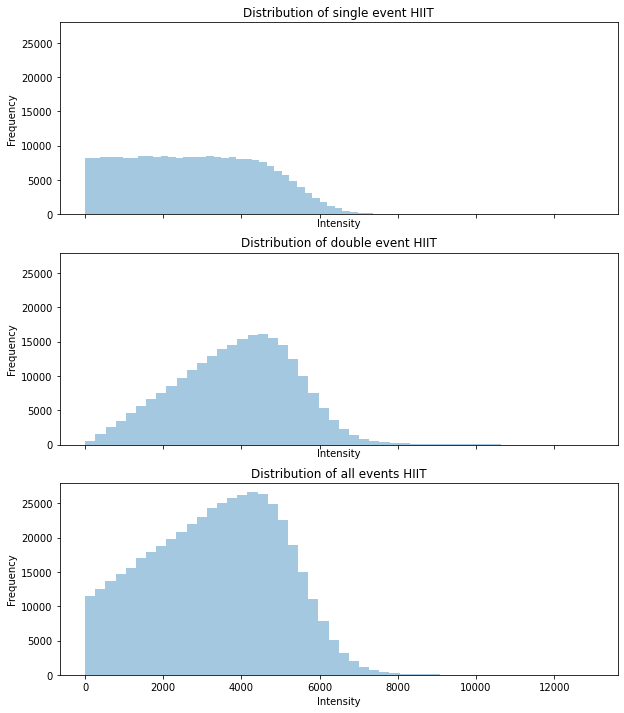

In [13]:
# Check how the highest intensity pixel varies with class in simulated data
highest_pixels_all = np.amax(images[c_val_idx].reshape(images[c_val_idx].shape[0], 256), axis=1)
highest_pixels_single = np.amax(images[c_val_idx][c_s_idx].reshape(images[c_val_idx][c_s_idx].shape[0], 256), axis=1)
highest_pixels_double = np.amax(images[c_val_idx][c_d_idx].reshape(images[c_val_idx][c_d_idx].shape[0], 256), axis=1)
fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True, sharey=True)
ax[0].set_title("Distribution of single event HIIT")
ax[0].set_xlabel("Intensity")
ax[0].set_ylabel("Frequency")
#n_bins = 20
#bins = np.arange(0, 2, 1/n_bins)
sns.distplot(highest_pixels_single, kde=False, ax=ax[0])

ax[1].set_title("Distribution of double event HIIT")
ax[1].set_xlabel("Intensity")
ax[1].set_ylabel("Frequency")
sns.distplot(highest_pixels_double, kde=False, ax=ax[1])

ax[2].set_title("Distribution of all events HIIT")
ax[2].set_xlabel("Intensity")
ax[2].set_ylabel("Frequency")
sns.distplot(highest_pixels_all, kde=False, ax=ax[2])

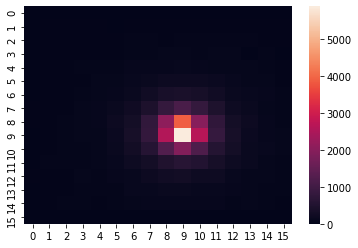

In [27]:
sns.heatmap(images[c_val_idx][c_s_idx][0].reshape(16,16))


In [29]:
print(256- np.count_nonzero(images[c_val_idx][c_s_idx][0].reshape(16,16)))

33


# Prediction of Energies and Positions
For this part of the project, the goal is to predict the energy and position of electrons in an event in the dataset. Previous work has made predictions of position for single-electron events with great performance ([MSU ML-Project, LaBollita](https://github.com/harrisonlabollita/MSU-Machine-Learning-Project)). We aim to reproduce and possibly improve the results from previous work on position prediction, predict the energy in single-electron events, and then move on to predict positions and energies in double-electron events.

This is essentially a regression problem, in that we have a continuous output variable that we want to relate to some input variables (our images). Similarly to classification, the convolutional layer works as a sort of feature extractor. The feature representation of our input is the fed as input to a regression layer which outputs our positions or energies. In fact, you can predict these values using linear regression, it just doesn't work very well. Thus, we enter the realm of "Deep Regression".

In part we intend to follow the work done in [A Comprehensive Analysis of Deep Regression](https://arxiv.org/abs/1803.08450), but using our own models built from scratch. Using pretrained networks is a possible path to try here, but currently we've met with implementation difficulties due to the size of our input.
We might solve this the same way as for classification, by simply not using all the layers. However, the article above also found that the placement of the regression layer was crucial, and performed best when placed after both fully connected layers.


## Single-electron events
Based on the architecture developed in previous work, we have made two separate models for prediction of position and energy. However, the only difference between the models for the single-electron case is the final output layer, which must account for outputting either one value in the energy case, or two values in the position case (x, y coordinates).

### Energy prediction results


In [22]:
# Load experiment and associated model (must be a saved model instance complete with weights)
e_experiment_id = "2137bd6d101c"
e_experiment = load_experiment(e_experiment_id)
e_model = tf.keras.models.load_model(repo_root + "models/" + e_experiment_id + ".h5")
# Print experiment metrics
print("==== Experiment metrics")
print(json.dumps(e_experiment['metrics'], indent=2))
print("====")

# Get validation indices used in the experiment and predict on validation set
e_val_idx = np.array(e_experiment['indices']['fold_0']['val_idx'])
# Predict on the validation set
e_prediction = e_model.predict(normalize_image_data(images[e_val_idx]))


==== Experiment metrics
{
  "r2_score": 0.9826797076330008,
  "mse": 0.001442644048834561,
  "rmse": 0.037982154346937205,
  "mae": 0.0174867983148799
}
====


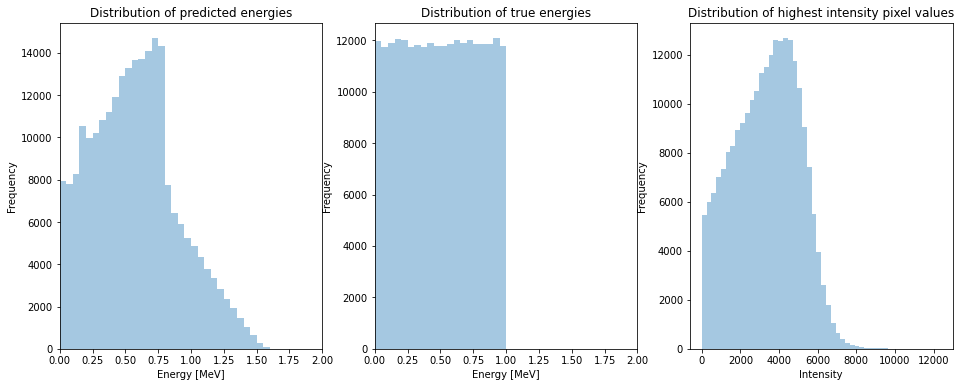

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(16,6))
ax[0].set_title("Distribution of predicted energies")
ax[0].set_xlabel("Energy [MeV]")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(0, 2)
n_bins = 20
bins = np.arange(0, 2, 1/n_bins)
sns.distplot(e_prediction, bins=bins, kde=False, ax=ax[0])

ax[1].set_title("Distribution of true energies")
ax[1].set_xlabel("Energy [MeV]")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(0, 2)
n_bins = 20
bins = np.arange(0, 2, 1/n_bins)
sns.distplot(energies[e_val_idx, 0], bins=bins, kde=False, ax=ax[1])

ax[2].set_title("Distribution of highest intensity pixel values")
ax[2].set_xlabel("Intensity")
ax[2].set_ylabel("Frequency")
#n_bins = 20
#bins = np.arange(0, 2, 1/n_bins)
highest_pixels = np.amax(images[e_val_idx].reshape(images[e_val_idx].shape[0],256), axis=1)
sns.distplot(highest_pixels, kde=False, ax=ax[2])



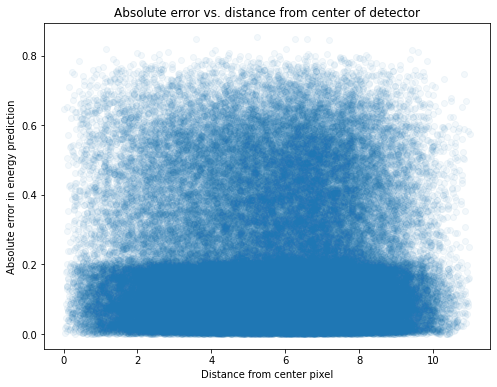

70591
166924


In [36]:
# Calculate distance from center point for each validation sample.
fig, ax = plt.subplots(figsize=(8,6))
new_idx = np.random.choice(np.arange(len(e_prediction)), 100000, replace=False)
residuals = energies[e_val_idx, 0].flatten() - e_prediction.flatten()
dist_from_center = np.sqrt((positions[e_val_idx, 0] - 7.5)**2 + (positions[e_val_idx, 1] - 7.5)**2)
ax.scatter(dist_from_center[new_idx], np.abs(residuals[new_idx]), alpha=0.05)
ax.set_xlabel("Distance from center pixel")
ax.set_ylabel("Absolute error in energy prediction")
ax.set_title("Absolute error vs. distance from center of detector")
plt.show()
print(np.count_nonzero(abs(residuals) > 0.2))
print(np.count_nonzero(abs(residuals) <= 0.2))

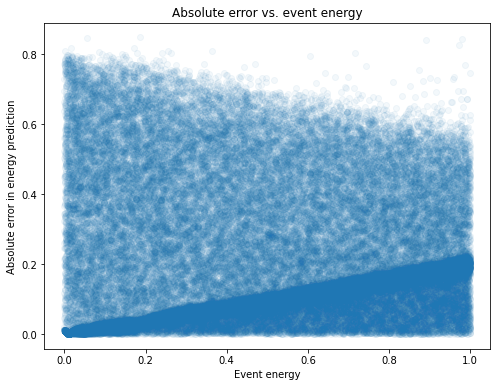

In [29]:
# Absolute error as a function of energy
# Calculate distance from center point for each validation sample.
fig, ax = plt.subplots(figsize=(8,6))
new_idx = np.random.choice(np.arange(len(e_prediction)), 100000, replace=False)
points = ax.scatter(energies[e_val_idx][new_idx, 0], np.abs(residuals[new_idx]), alpha=0.05)
#plt.colorbar(points)
ax.set_xlabel("Event energy")
ax.set_ylabel("Absolute error in energy prediction")
ax.set_title("Absolute error vs. event energy")
plt.show()

### Position prediction results

In [31]:
# Load experiment and associated model (must be a saved model instance complete with weights)
p_experiment_id = "337cafc233f7"
p_experiment = load_experiment(p_experiment_id)
p_model = tf.keras.models.load_model(repo_root + "models/" + p_experiment_id + ".h5")
# Print experiment metrics
print("==== Experiment metrics")
print(json.dumps(p_experiment['metrics'], indent=2))
print("====")

# Get validation indices used in the experiment and predict on validation set
p_val_idx = np.array(p_experiment['indices']['fold_0']['val_idx'])
# Predict on the validation set
p_prediction = p_model.predict(normalize_image_data(images[p_val_idx]))


==== Experiment metrics
{
  "r2_score": 0.9991389940117517,
  "mse": 6.012267605743713e-05,
  "rmse": 0.007753881354356483,
  "mae": 0.003687259271068965
}
====


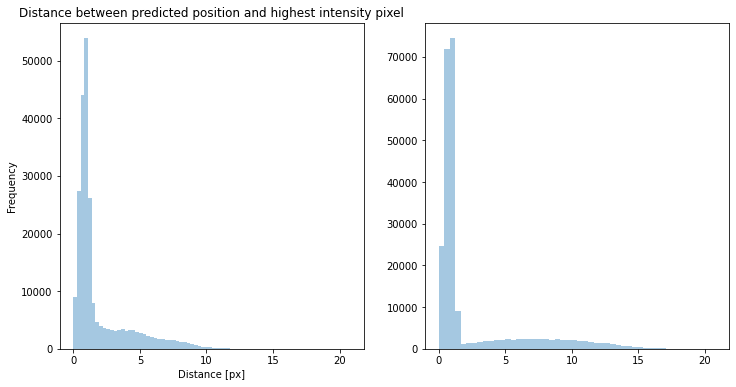

In [36]:
# === Get location of highest intensity pixels in the images
# Reshape input array to a 2D array with rows being kept as with original array.
# Then, get indices of max values along the columns.
max_idx = images[p_val_idx].reshape(images[p_val_idx].shape[0],-1).argmax(1)
# Get unravel indices corresponding to original shape of A
maxpos_vect = np.column_stack(np.unravel_index(max_idx, images[p_val_idx,:,:].shape))
# Distribution around highest intensity pixel
dist = np.sqrt((maxpos_vect[:, 1] - p_prediction[:, 0]*16)**2 + (maxpos_vect[:, 2] - p_prediction[:, 1]*16)**2)
dist2 = np.sqrt((maxpos_vect[:, 1] - positions[p_val_idx, 0])**2 + (maxpos_vect[:, 2] - positions[p_val_idx, 1])**2)
fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=True)
ax[0].set_title("Distance between predicted position and highest intensity pixel")
ax[0].set_xlabel("Distance [px]")
ax[0].set_ylabel("Frequency")
sns.distplot(dist, kde=False, ax=ax[0])
sns.distplot(dist2, kde=False, ax=ax[1])

# TODO
# Look into energy distribution of the tail events

## Double-electron events
Based on the architecture used in classification, we have made two separate models for prediction of position and energy. This is also partly because of the difference in output, but also because we assume the tasks of predicting these quantities may be fundamentally different. It is also trivial to attempt prediction of positions using the energy model (and vice versa), as long as the final output layer is adjusted.

### Energy prediction results
500k events, R2 = 0.4552 (3 epochs)

### Position prediction results
500k events, R2 = 0.4819 after 3 epochs (earlystopping)


### Why the low score compared with single event?
* Loss functions
* Target and input representation
* Convolution blocks - complexity of network
* Fine-Tuning (ref. article, on pretrained networks)
* Regression layer placement
* Is the CNNs spacial invariance affecting its ability to predict positions well in multiple-object cases?

Papers to check out:
* [Numerical Coordinate Regression with CNNs](https://arxiv.org/abs/1801.07372)
* [DeepDistance](https://arxiv.org/abs/1908.11211)
* [A Comprehensive Analysis of Deep Regression](https://arxiv.org/abs/1803.08450)
* [Human pose estimation via Convolutional Part Heatmap Regression](https://arxiv.org/abs/1609.01743)
* [Evaluating and Calibrating Uncertainty Prediction in Regression Tasks](https://arxiv.org/abs/1905.11659)


Group by distance to check if there are some events that are dominating the results.
Also for relative energies. 
* Can we treat the data as heatmaps? Or can we output heatmaps from the CNN?
* Look at object detection

# Applying models to experimental data

In [14]:
DATA_PATH = "../../data/real/"
DATA_FILENAME = "anodedata_500k.txt"
MODEL_PATH = "../../models/"
RESULTS_PATH =  "../../results/"
CLASSIFIER = "367e35da671b"
ENERGY_MODEL = "2137bd6d101c"
POSITION_MODEL = "337cafc233f7"

In [15]:
# Load 
events, images = import_real_data(DATA_PATH + DATA_FILENAME) # images not normalized
#images = normalize_image_data(images)

# load classification results (doesn't contain images)
with open(RESULTS_PATH + "events_classified_" + DATA_FILENAME[:-4] 
          + "_C_" + CLASSIFIER
          + "_E_" + ENERGY_MODEL
          + "_P_" + POSITION_MODEL
          + ".json") as fp:
    events = json.load(fp)

## Classification
Model: 367e35da671b

|Event descriptor | Event type                   | singles | doubles |
| :---           |  :---:                       | :---:   | :---:   |
|        1        |           Implant            |   546   |  89171  |
|        2        |            Decay             |  32812  | 227335  |
|        4        |          Light ion           |  2276   | 147224  |
|        9        |   Implant + Double (time)    |    0    |    1    |
|       10        |    Decay + Double (time)     |   143   |   471   |
|       12        |  Light ion + Double (time)   |    0    |    3    |
|       16        |        Double (space)        |    0    |   17    |

Same model - gaussian smooth applied to images. sigma=1

|Event descriptor | Event type                   | singles | doubles |
| :---           |  :---:                       | :---:   | :---:   |
|        1        |           Implant            |   510   |  89207  |
|        2        |            Decay             |  24867  | 235280  |
|        4        |          Light ion           |  2152   | 147348  |
|        9        |   Implant + Double (time)    |    0    |    1    |
|       10        |    Decay + Double (time)     |   116   |   498   |
|       12        |  Light ion + Double (time)   |    0    |    3    |
|       16        |        Double (space)        |    0    |   17    |

Text(0.5, 1.0, 'Smoothed single')

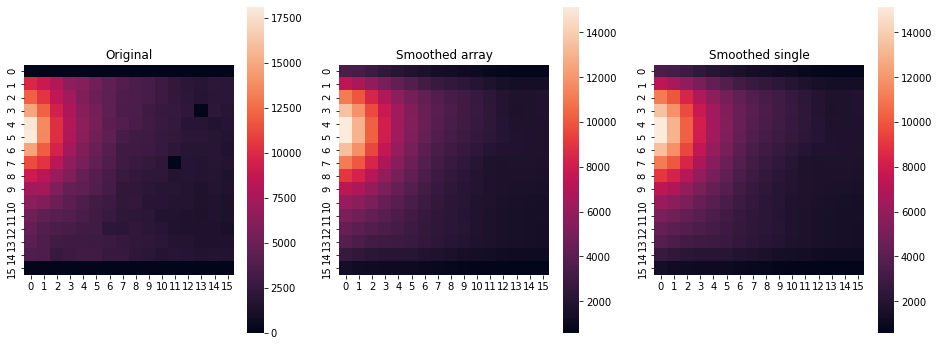

In [103]:
# Test gaussian filtering on real data for classification purposes
from scipy.ndimage import gaussian_filter

test_imgs = images[:10].reshape(10, 16, 16).copy()
test_idx = 3
smooth_imgs = test_imgs.copy()

# Smooth the images, elementwise.
for i in range(smooth_imgs.shape[0]):
    smooth_imgs[i] = gaussian_filter(smooth_imgs[i], sigma=1)
    
#smooth_imgs = gaussian_filter(test_imgs, sigma=1)
img1 = gaussian_filter(test_imgs[test_idx], sigma=1)

# Plot the images
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
sns.heatmap(test_imgs[test_idx], square=True, ax=ax[0])
ax[0].set_title('Original')
sns.heatmap(smooth_imgs[test_idx], square=True, ax=ax[1])
ax[1].set_title('Smoothed array')
sns.heatmap(img1, square=True, ax=ax[2])
ax[2].set_title('Smoothed single')



In [24]:
print(sorted(list(events.keys())[:10]))
print(events['0']['image_idx'])

['0', '10', '11', '12', '13', '17', '2', '26', '27', '5']
0


In [22]:
print(events['0'])

{'event_class': 'double', 'event_descriptor': 2, 'image_idx': 0}


(10, 16, 16, 1)


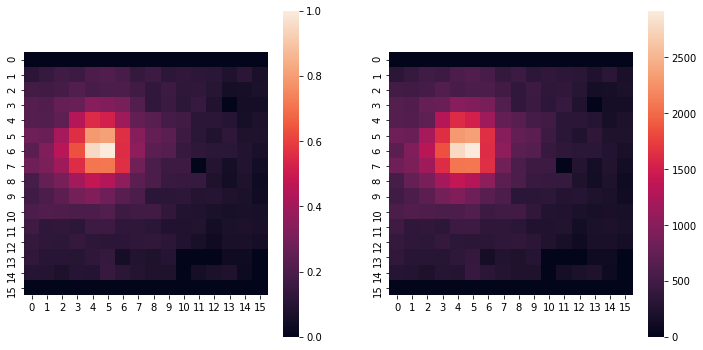

In [114]:
test_imgs = test_imgs.reshape(10,16,16,1)
test_img_max = np.amax(test_imgs.reshape(test_imgs.shape[0], 256), axis=1)
test_img_min = np.amin(test_imgs.reshape(test_imgs.shape[0], 256), axis=1)
term_top = test_imgs - test_img_min.reshape(test_imgs.shape[0], 1, 1, 1)
term_bottom = (test_img_max - test_img_min).reshape(test_imgs.shape[0], 1, 1, 1)
test_imgs_scaled = term_top / term_bottom
print(test_imgs_scaled.shape)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(test_imgs_scaled[0].reshape(16,16), square=True, ax=ax[0])
sns.heatmap(images[0].reshape(16,16), square=True, ax=ax[1])

In [5]:
single_keys = []
double_keys = []
single_idx = []
double_idx = []
for k in events.keys():
    if events[k]['event_class'] == 'single':
        single_keys.append(k)
        single_idx.append(events[k]['image_idx'])
    if events[k]['event_class'] == 'double':
        double_keys.append(k)
        double_idx.append(events[k]['image_idx'])
single_idx = np.array(single_idx)
double_idx = np.array(double_idx)

## Prediction - Single events
Prediction of energy and position for events classified as single

### Position prediction
In the absence of ground truth positions for the events, we compare results for experimental and simulated data by looking at how the predicted positions are distributed around the highest intensity pixel in the image.

In [6]:
# === Get location of highest intensity pixels in the images
# Reshape input array to a 2D array with rows being kept as with original array.
# Then, get indices of max values along the columns.
max_idx_single = images[single_idx].reshape(images[single_idx].shape[0],-1).argmax(1)
max_idx_double = images[double_idx].reshape(images[double_idx].shape[0],-1).argmax(1)
# Get unravel indices corresponding to original shape of A
maxpos_vect_single = np.column_stack(np.unravel_index(max_idx_single, images[single_idx,:,:].shape))
maxpos_vect_double = np.column_stack(np.unravel_index(max_idx_double, images[double_idx,:,:].shape))

# === Get predicted positions for all single events
positions_single = np.array([events[k]['predicted_position'] for k in single_keys])*16
#positions_double = np.array([events[k]['predicted_position'] for k in double_keys])*16

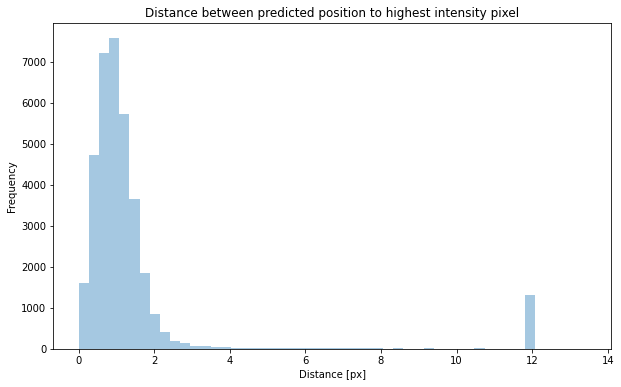

In [7]:
dist = np.sqrt((maxpos_vect_single[:, 1] - positions_single[:, 0])**2 + (maxpos_vect_single[:, 2] - positions_single[:, 1])**2)
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Distance between predicted position to highest intensity pixel")
ax.set_xlabel("Distance [px]")
ax.set_ylabel("Frequency")
sns.distplot(dist, kde=False, ax=ax)

### Energy prediction

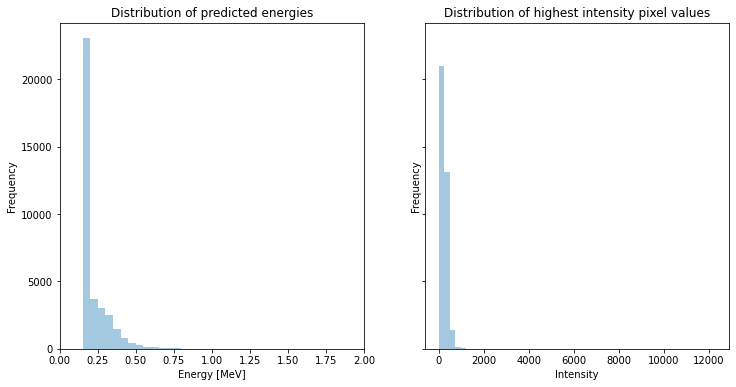

In [28]:
# === Get predicted energy for all single events
predicted_energies = np.array([events[k]['predicted_energy'] for k in single_keys])*16
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
ax[0].set_title("Distribution of predicted energies")
ax[0].set_xlabel("Energy [MeV]")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(0, 2)
n_bins = 20
bins = np.arange(0, 2, 1/n_bins)
sns.distplot(predicted_energies, bins=bins, kde=False, ax=ax[0])

ax[1].set_title("Distribution of highest intensity pixel values")
ax[1].set_xlabel("Intensity")
ax[1].set_ylabel("Frequency")
highest_pixels = np.amax(images[single_idx].reshape(images[single_idx].shape[0], 256), axis=1)
sns.distplot(highest_pixels, kde=False, ax=ax[1])

### Comparison of single and double events

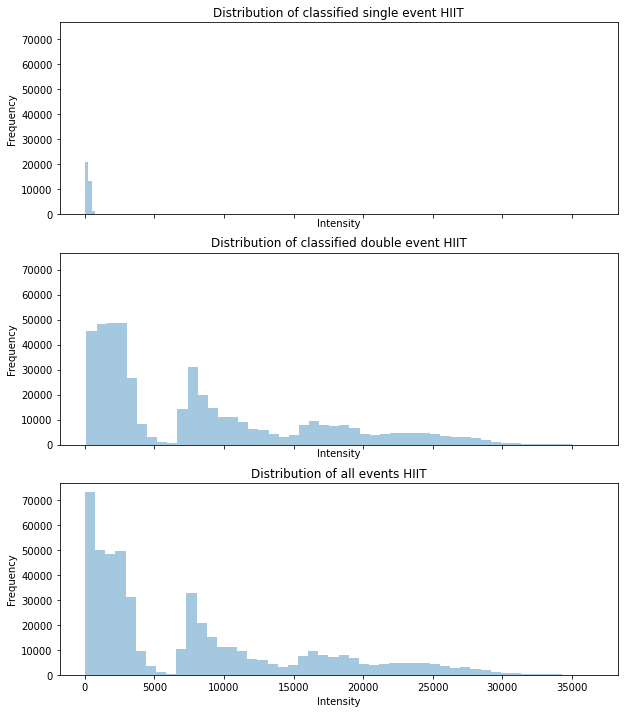

In [26]:
highest_pixels_all = np.amax(images.reshape(images.shape[0], 256), axis=1)
highest_pixels_single = np.amax(images[single_idx].reshape(images[single_idx].shape[0], 256), axis=1)
highest_pixels_double = np.amax(images[double_idx].reshape(images[double_idx].shape[0], 256), axis=1)
fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True, sharey=True)
ax[0].set_title("Distribution of classified single event HIIT")
ax[0].set_xlabel("Intensity")
ax[0].set_ylabel("Frequency")
#n_bins = 20
#bins = np.arange(0, 2, 1/n_bins)
sns.distplot(highest_pixels_single, kde=False, ax=ax[0])

ax[1].set_title("Distribution of classified double event HIIT")
ax[1].set_xlabel("Intensity")
ax[1].set_ylabel("Frequency")
sns.distplot(highest_pixels_double, kde=False, ax=ax[1])

ax[2].set_title("Distribution of all events HIIT")
ax[2].set_xlabel("Intensity")
ax[2].set_ylabel("Frequency")
sns.distplot(highest_pixels_all, kde=False, ax=ax[2])

In [27]:
print("mean single:", np.mean(highest_pixels_single))
print("max single:", np.amax(highest_pixels_single))
print("min single:", np.amin(highest_pixels_single))
print("median single:", np.median(highest_pixels_single))
print("num > 1250 intensity:", np.count_nonzero(highest_pixels_single > 1250))
print()
print("mean double", np.mean(highest_pixels_double))
print("max double", np.amax(highest_pixels_double))
print("min double", np.amin(highest_pixels_double))
print("median double", np.median(highest_pixels_double))

mean single: 237.489
max single: 12287.8
min single: 0.0
median single: 213.729
num > 1250 intensity: 32

mean double 8262.435
max double 36463.3
min double 108.39
median double 7007.7305


# Interpretability of models


## LIME
LIME (Local Interpretable Model-Agnostic Explanations, [Module](https://github.com/marcotcr/lime), [Paper](https://arxiv.org/abs/1602.04938)) is a project that aims to explain what classifiers are doing.
Have done preliminary testing with classification, but:
* See LIME notebook

If we can explain the behaviour of the classifier to a greater extent, perhaps this can aid in the regression.

# Unsupervised Methods
Unsupervised methods do not require labeled data, but rather look for underlying symmetries and structures in the data itself.

Currently looking into:
* Variational Autoencoders

# Outline for thesis
Start with the standard framework, similar to projects.
## Abstract
## Introduction
### Motivate the reader, why is this project relevant
## Theory
### LinReg
### LogReg
### NNs, backprop
### Convolutions
## Implementation
### Testing and training with simulated data
### Examples with current methods